In [1]:
import torch
import torch.nn.functional as F
import os
import sys
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
from sam2.sam2_image_predictor import SAM2ImagePredictor
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
from pipeline_flux_bg_replace import FluxPipeline
from transformer_flux_bg_replace import FluxTransformer2DModel
from bg_replace_attn_utils import register_bg_replace_attention_control, register_reasoning_attention_control
from diffusers.utils.torch_utils import randn_tensor
from diffusers.models.attention_processor import FluxAttnProcessor2_0
from utils import resize_and_concat_images, get_mask_by_click, resize_and_get_coordinates, get_index_from_subject, \
    derive_fg_mask_from_attn, remove_small_white_regions, sample_indices, erode_image, validate_fg_mask_mode

In [2]:
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-dev", torch_dtype=torch.bfloat16)
flux_transfomer = FluxTransformer2DModel.from_pretrained("black-forest-labs/FLUX.1-dev", subfolder="transformer", torch_dtype=torch.bfloat16)
pipe.transformer = flux_transfomer
device = "cuda:0"
pipe = pipe.to(device)
predictor = SAM2ImagePredictor.from_pretrained("facebook/sam2-hiera-large")

height = 1024
width = 1024

processor_args = {
    "start_step": 0,
    "start_layer": 0,
    "layer_idx":list(range(0,57)),
    "step_idx": list(range(0,45)),
    "total_layers": 57,
    "total_steps": 50,
}

fg_mask_mode = 'auto' #auto or manual
shift = (0,0) # Setting it to a non-zero value enables the Object Moving application, e.g., (10, 10).
auto_gen_fg_mask = validate_fg_mask_mode(fg_mask_mode)

def register_ori_attention(model):
    attn_procs = FluxAttnProcessor2_0()
    model.transformer.set_attn_processor(attn_procs)
    print(f"Model {model.transformer.__class__.__name__} is registered attention processor: FluxAttnProcessor2_0")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
seed = 2
prompt_subject = [["A sports car on the road", "A snowing day"], 'car'] #[[src_prompt, tar_background_word], foreground word]
subject_idx_list = get_index_from_subject(pipe, prompt_subject[0][0], prompt_subject[1])

Reasoning at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Reasoning at U-Net layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Reasoning


  0%|          | 0/50 [00:00<?, ?it/s]

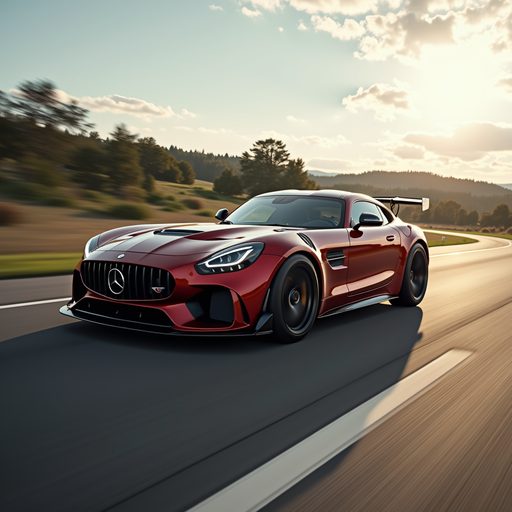

In [4]:
if auto_gen_fg_mask:
    register_reasoning_attention_control(pipe, **processor_args)
else:
    register_ori_attention(pipe)
    
ori_image = pipe(
    prompt_subject[0][0],
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    generator=torch.Generator("cuda").manual_seed(seed),
).images[0]
display(resize_and_concat_images([ori_image]))

/mnt/slurm_home/tywei/anaconda3/envs/freeflux/lib/python3.10/site-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


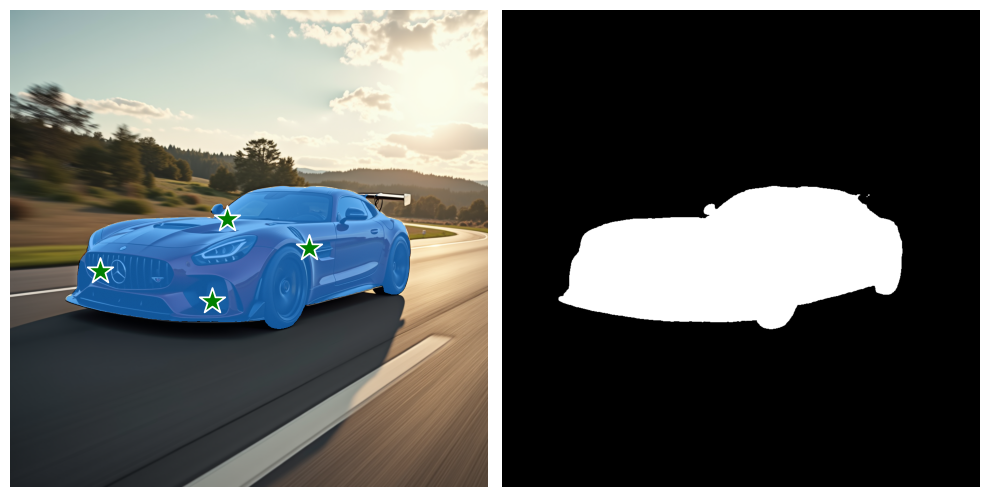

In [5]:
if auto_gen_fg_mask:
    image = np.array(ori_image.convert("RGB"))
    global_store = pipe.transformer.single_transformer_blocks[1].attn.processor.global_store
    derived_mask = 255 * derive_fg_mask_from_attn(global_store, subject_idx_list, mask_threshold=0.3, height=height//16, width=width//16).numpy().astype(np.uint8)
    mask_for_point = remove_small_white_regions(derived_mask)
    bg_index = sample_indices(mask_for_point, value=0, num_samples=4)
    fg_source_mask = erode_image(mask_for_point)
    fg_index = sample_indices(fg_source_mask, value=1, num_samples=4, farthest=True)
    # point_list = fg_index+bg_index
    # lable_list = len(fg_index)*[1]+len(bg_index)*[0]

    point_list = fg_index
    lable_list = len(fg_index)*[1]
    predcted_source_mask = get_mask_by_click(image.astype(np.uint8), predictor=predictor, point_list=point_list, lable_list=lable_list, device=device)
else:
    predcted_source_mask = get_mask_by_click(np.array(ori_image).astype(np.uint8), predictor=predictor, point_list=[[500, 500], [350, 280], [700,550]], lable_list=[1,0,1], device=device)

In [6]:
source_idx_list, target_idx_list, inpainted_idx_list, remain_idx_list = resize_and_get_coordinates(predcted_source_mask, [width//16, height//16], shift=shift)
prompt = prompt_subject[0]
generator = torch.Generator("cuda").manual_seed(seed)
shape = (1, 16, height//8, width//8)
latents = randn_tensor(shape, generator=generator, device=pipe._execution_device, dtype=torch.bfloat16).expand(len(prompt), -1, -1, -1)
latents = pipe._pack_latents(latents, len(prompt), 16, height//8, width//8)

Background Replacement at denoising steps:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44]
Background Replacement at U-Net layers:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Model FluxTransformer2DModel is registered attention processor: FluxAttnProcessor2_0_Bg_Replace


  0%|          | 0/50 [00:00<?, ?it/s]

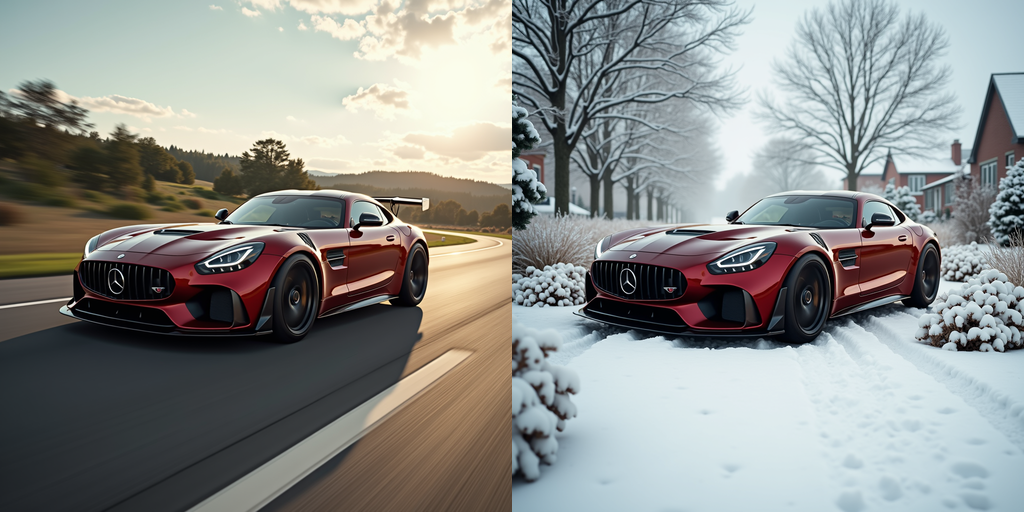

In [7]:
register_bg_replace_attention_control(pipe, **processor_args)
image_masa_list = pipe(
    prompt,
    height=height,
    width=width,
    guidance_scale=3.5,
    num_inference_steps=50,
    max_sequence_length=512,
    latents=latents,
    src_tar_inpaint_idx_list=[source_idx_list, target_idx_list, inpainted_idx_list, remain_idx_list],
).images
display(resize_and_concat_images(image_masa_list))